In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import mne
import os
import pandas as pd

import tqdm
import IPython
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models import AlexNet
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import pickle
import random
from tqdm import tqdm

In [2]:
def read_file(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [3]:
class SpecDataset(Dataset):
    def __init__(self, annotations_file, spec_dir):
        self.spec_labels = pd.read_csv(annotations_file)
        self.spec_dir = spec_dir

    def __len__(self):
        return len(self.spec_labels)

    def __getitem__(self, idx):
        spec_path = self.spec_labels.iloc[idx, 0]
        spectogram = read_file(spec_path)
        label = self.spec_labels.iloc[idx, 1]
        return spectogram, label
    
eeg_dataset = SpecDataset('./annotations.csv','./spec_files')
train_dataloader = DataLoader(eeg_dataset, batch_size=64, shuffle=True)

In [4]:
#creating datasets from numpy arrays.
annotations = pd.read_csv('./annotations.csv', names=['filename', 'class'])
files = list(annotations['filename'])

x_full_pad = []
y_full_np = np.array(list(annotations['class']))
for file in files:
    x_full_pad.append(read_file(file))
x_full_pad = np.array(x_full_pad)

In [5]:
indexes = [i for i in range(len(x_full_pad))]

In [6]:
train_len = 48
val_len = len(indexes) - train_len
train_indexes = random.sample(indexes,train_len)
val_indexes = list(set(indexes).difference(set(train_indexes)))

In [143]:
len(train_indexes)

48

In [144]:
len(val_indexes)

15

In [80]:
x_train_pad = []
y_train_np = []
for index in train_indexes:
    x_train_pad.append(x_full_pad[index])
    y_train_np.append(y_full_np[index])
x_train_pad = np.array(x_train_pad)
y_train_np = np.array(y_train_np)
    
x_val_pad = []
y_val_np = []
for index in val_indexes:
    x_val_pad.append(x_full_pad[index])
    y_val_np.append(y_full_np[index])
x_val_pad = np.array(x_val_pad)
y_val_np = np.array(y_val_np)
    
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad.astype(np.float32)), torch.from_numpy(y_train_np.astype(np.int64)))
valid_data = TensorDataset(torch.from_numpy(x_val_pad.astype(np.float32)), torch.from_numpy(y_val_np.astype(np.int64)))

In [100]:
train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(valid_data, batch_size=5, shuffle=True)

In [ ]:
# @title Import Alexnet
# @markdown This cell gives you the `alexnet` model as well as the `input_image` and `input_batch` variables used below
#import requests, urllib

# original link: https://s3.amazonaws.com/pytorch/models/alexnet-owt-4df8aa71.pth
# state_dict = torch.hub.load_state_dict_from_url("https://osf.io/9dzeu/download")

# alexnet = AlexNet()
# alexnet.load_state_dict(state_dict=state_dict)

# url, filename = ("https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ModernConvnets/static/dog.jpg", "dog.jpg")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)

# input_image = Image.open(filename)
# preprocess = transforms.Compose([
#                                  transforms.Resize(256),
#                                  transforms.CenterCrop(224),
#                                  transforms.ToTensor(),
#                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                       std=[0.229, 0.224, 0.225]),
#                                  ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# # move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#   input_batch = input_batch.cuda()
#   alexnet.cuda()

In [101]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
                "if possible, in the menu under `Runtime` -> "
                "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

DEVICE = set_device()

GPU is enabled in this notebook.


In [132]:
def train(model, device, train_loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    epochs = len(train_loader)
    losses = []
    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                losses.append(loss.item())
                #time.sleep(0.1)
    return losses

def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [146]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net, self).__init__()
        self.fc1 = nn.Linear(9*1919, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = x.view(-1, 9*1919)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = F.relu(x)
        return x

## Uncomment the lines below to train your network
test_net = Test_Net().to(DEVICE)
accuracy = []
losses_arrays = []
for i in range(500):
    print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in test_net.parameters())))
    losses = train(test_net, DEVICE, train_dataloader)
    losses_arrays.append(losses)
    acc = test(test_net, DEVICE, test_dataloader)
    print(acc)
    accuracy.append(acc)

 60%|████████████████████████████████████████▊                           | 6/10 [00:00<00:00, 55.30batch/s, loss=0.706]

Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.584]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.533]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.527]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.631]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.683]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                             | 0/10 [00:00<?, ?batch/s, loss=1.04]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.905]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.618]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.334]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.395]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.339]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                             | 0/10 [00:00<?, ?batch/s, loss=0.46]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.241]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.272]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.837]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.304]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.783]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.364]

46.666666666666664
Total Parameters in Network   17688578


 70%|███████████████████████████████████████████████▌                    | 7/10 [00:00<00:00, 60.93batch/s, loss=0.475]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.451]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.134]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.278]

46.666666666666664
Total Parameters in Network   17688578


 50%|██████████████████████████████████                                  | 5/10 [00:00<00:00, 49.52batch/s, loss=0.493]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.333]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.292]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.212]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.402]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.305]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0713]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.466]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.575]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.101]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.101]

46.666666666666664
Total Parameters in Network   17688578


  0%|                                                                             | 0/10 [00:00<?, ?batch/s, loss=0.26]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.265]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.294]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0533]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.366]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.226]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0817]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0954]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.199]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.181]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.193]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.309]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0808]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0656]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.105]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.222]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.215]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.167]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0723]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.282]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.189]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.171]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0301]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0343]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.121]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.222]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.108]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0479]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0259]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0261]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0883]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0231]

53.333333333333336
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0227]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.203]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.101]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.117]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0799]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.018]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0412]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0864]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0893]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0696]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0208]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0126]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0264]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0787]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.106]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.039]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0104]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0229]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0155]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0255]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0306]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.143]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0535]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0596]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0146]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0272]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0058]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0502]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.067]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0111]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0084]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0183]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0193]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.016]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00649]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0578]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0248]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0293]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00886]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0483]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.122]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0365]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.028]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0433]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0172]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00599]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0249]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00878]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0221]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0118]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.013]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00797]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00812]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0342]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0102]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0219]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0202]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0421]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0393]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0153]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00206]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0376]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0144]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0142]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.027]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0388]

60.0
Total Parameters in Network   17688578


 60%|████████████████████████████████████████▏                          | 6/10 [00:00<00:00, 54.42batch/s, loss=0.0078]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.007]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00865]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0293]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0258]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00834]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0261]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.014]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0271]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0382]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0298]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0328]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.024]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0274]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0213]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.056]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00379]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00953]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00179]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0268]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0171]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0157]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00154]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0148]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00304]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0247]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00439]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00483]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0221]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0202]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00332]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.018]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00684]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0223]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00792]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.002]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0119]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00336]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0223]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0296]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00364]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.012]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0253]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.038]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0252]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0304]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00388]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0138]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00808]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00293]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00155]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0018]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00862]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0036]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00107]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00243]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0246]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00588]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00386]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0148]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0166]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00131]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.014]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00098]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00644]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00935]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00418]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.017]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00639]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00935]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0146]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00655]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.013]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00678]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00451]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0115]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00998]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0033]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0116]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0112]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00806]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00652]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0134]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00979]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000882]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0157]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00213]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00382]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0125]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000845]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00498]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00161]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.016]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00573]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.019]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00148]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00162]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00104]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0108]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00794]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0114]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0103]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00409]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0031]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00714]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00918]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00661]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0058]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0145]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00995]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00234]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.012]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00352]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00223]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00234]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00646]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00728]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0013]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00717]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0141]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00684]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0113]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00371]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00497]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00882]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00333]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00297]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0155]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00963]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▉                    | 7/10 [00:00<00:00, 60.37batch/s, loss=0.0031]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00253]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00308]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00205]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▏                   | 7/10 [00:00<00:00, 61.57batch/s, loss=0.00857]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00662]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0125]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0111]

60.0
Total Parameters in Network   17688578


100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.58batch/s, loss=0.000457]

60.0
Total Parameters in Network   17688578



  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00117]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0039]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000728]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0103]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00786]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00688]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00277]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00537]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00716]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00106]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00104]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0095]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0133]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00237]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00725]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00753]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00126]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00504]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0145]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00303]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000981]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0112]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0142]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00714]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00384]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00458]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00373]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0107]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00852]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00197]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00764]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00218]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0105]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00241]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00427]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00219]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000666]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00182]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00679]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00679]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00812]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00477]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000478]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00584]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00203]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0107]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0062]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00174]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00918]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000505]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00208]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00894]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00183]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.00batch/s, loss=0.00127]

60.0
Total Parameters in Network   17688578



  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▏                   | 7/10 [00:00<00:00, 61.53batch/s, loss=0.00115]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 60%|████████████████████████████████████████▏                          | 6/10 [00:00<00:00, 54.38batch/s, loss=0.0109]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00603]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00815]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 60%|███████████████████████████████████████▌                          | 6/10 [00:00<00:00, 56.28batch/s, loss=0.00669]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▏                   | 7/10 [00:00<00:00, 61.41batch/s, loss=0.00121]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 70%|█████████████████████████████████████████████▌                   | 7/10 [00:00<00:00, 57.95batch/s, loss=0.000565]

60.0
Total Parameters in Network   17688578


 60%|████████████████████████████████████████▏                          | 6/10 [00:00<00:00, 57.28batch/s, loss=0.0054]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00136]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00499]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00391]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00224]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00119]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00276]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00038]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00207]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0132]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00702]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0074]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00198]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00384]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00348]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00568]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00487]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0013]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00313]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000407]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00538]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000379]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00527]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00801]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000405]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00543]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00538]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00297]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00503]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0117]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00489]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0018]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00582]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00112]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.002]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00498]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00193]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00224]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000728]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00795]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00212]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00112]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00457]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00105]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000597]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00201]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000678]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0024]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00229]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00864]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00161]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00639]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00187]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.006]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000664]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00532]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00117]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00493]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00293]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000446]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0013]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00505]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00053]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00469]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000701]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000622]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00303]

60.0
Total Parameters in Network   17688578


  0%|                                                                            | 0/10 [00:00<?, ?batch/s, loss=0.001]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00728]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0027]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00425]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00143]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0016]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00051]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00258]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00372]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00046]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00121]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000632]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000438]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00124]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000389]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00121]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00458]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00243]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0018]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00565]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00106]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▏                   | 7/10 [00:00<00:00, 59.56batch/s, loss=0.00102]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00106]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00164]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00409]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00188]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000623]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0015]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00285]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00588]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00165]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000805]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


 70%|██████████████████████████████████████████████▏                   | 7/10 [00:00<00:00, 64.51batch/s, loss=0.00199]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00602]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000697]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00403]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00118]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00269]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000925]

60.0
Total Parameters in Network   17688578


  0%|                                                                           | 0/10 [00:00<?, ?batch/s, loss=0.0036]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00176]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000358]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00456]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000177]

60.0
Total Parameters in Network   17688578


  0%|                                                                         | 0/10 [00:00<?, ?batch/s, loss=0.000915]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00494]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00393]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00322]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00313]

60.0
Total Parameters in Network   17688578


  0%|                                                                                        | 0/10 [00:00<?, ?batch/s]

60.0
Total Parameters in Network   17688578


  0%|                                                                          | 0/10 [00:00<?, ?batch/s, loss=0.00115]

60.0
Total Parameters in Network   17688578


100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.71batch/s, loss=0.00851]


60.0


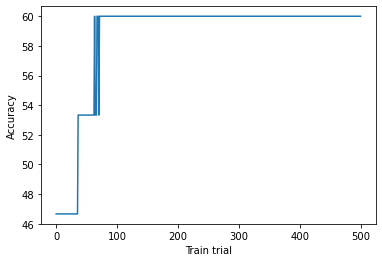

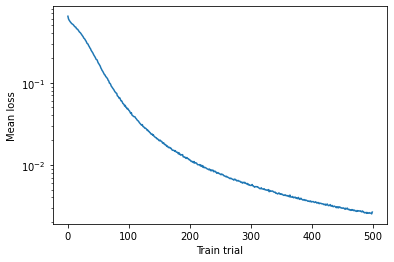

In [147]:
plt.xlabel('Train trial')
plt.ylabel('Accuracy')
plt.plot(accuracy)
plt.show()
plt.xlabel('Train trial')
plt.ylabel('Mean loss')
plt.yscale('log')
to_plot = np.array(losses_arrays).mean(axis=1)
plt.plot(to_plot)
plt.show()

In [24]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9*1919, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
num_ftrs = alexnet.fc.in_features
alexnet.classifier[6] = nn.Linear(4096, 2)
# reset final fully connected layer, number of classes = types of Pokemon = 9
alexnet.fc = nn.Linear(num_ftrs, 2)
alexnet.to(DEVICE)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune ResNet

pretrained_accs = []
for epoch in tqdm.tqdm(range(10)):
  # Train loop
  for batch in train_dataloader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = alexnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(y_val_np)
    for batch in test_dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = alexnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    # Plot accuracy
    pretrained_accs.append(total_correct / total)
    plt.plot(pretrained_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Pokemon prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

In [ ]:
alexnet.eval()